## Segmenting and Clustering Neighborhoods in Toronto
#### Date: November 28th, 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library


### Extract data from the following URL link into a dataframe called "df"

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
df = pd.read_html(url, header = 0)

### Find number of tables extracted from webscraping

In [4]:
len(df)

3

### Select the first table extracted

In [5]:
Postal_Codes=df[0]

In [6]:
Postal_Codes.shape

(180, 3)

### Filter out the "Not Assigned" Boroughs from the Dataset

In [7]:
Postal_Codes = Postal_Codes[Postal_Codes.Borough != 'Not assigned']

In [8]:
Postal_Codes.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
Postal_Codes.shape

(103, 3)

### Load the coordinates dataset and join onto the neighbourhoods dataset

In [10]:
Coordinates = pd.read_csv('Geospatial_Coordinates.csv')

In [11]:
result = Postal_Codes.merge(Coordinates, left_on='Postal Code', right_on='Postal Code')

In [12]:
result.head(30)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [13]:
result.shape

(103, 5)

### Plot all coordinates onto a map

In [14]:
venues_map = folium.Map(location=[result.Latitude.mean(),result.Longitude.mean()]) # generate map
venues_map

# add the Italian restaurants as blue circle markers
for lat, lng in zip(result.Latitude, result.Longitude):
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Apply "elbow curve" to determine K value to be used in KMeans Clustering

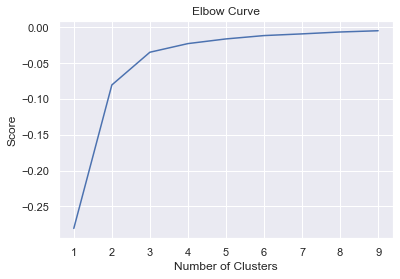

In [15]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = result[['Latitude']]
X_axis = result[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Have chosen K = 3 for Kmeans Clustering Algorithm

In [16]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(result[['Latitude','Longitude']]) # Compute k-means clustering.
result['cluster_label'] = kmeans.fit_predict(result[['Latitude','Longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(result[['Latitude','Longitude']]) # Labels of each point
result.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
0,M3A,North York,Parkwoods,43.753259,-79.329656,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1
7,M3B,North York,Don Mills,43.745906,-79.352188,2
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2


In [17]:
venues_map = folium.Map(location=[result.Latitude.mean(),result.Longitude.mean()]) # generate map
venues_map

kclusters = 3
colors_array = cm.brg(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the Italian restaurants as blue circle markers
for lat, lng,label in zip(result.Latitude, result.Longitude, result.cluster_label):
    folium.CircleMarker(
        [lat,lng],
        radius=10,
        fill = True,
        label = label,
        color='black',
        fill_color=rainbow[label-1],
        fill_opacity=1
    ).add_to(venues_map)

# display map
venues_map

### Similar exercise to above but with Borough filtered to containing the word "Toronto"

In [18]:
result_subset = result[result['Borough'].str.contains("Toronto")]

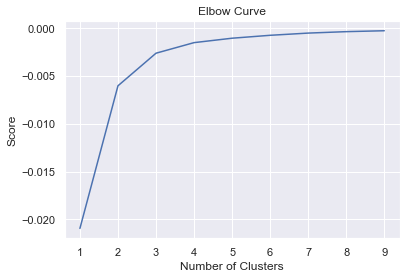

In [19]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = result_subset[['Latitude']]
X_axis = result_subset[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [20]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(result_subset[['Latitude','Longitude']]) # Compute k-means clustering.
result_subset['cluster_label'] = kmeans.fit_predict(result_subset[['Latitude','Longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(result_subset[['Latitude','Longitude']]) # Labels of each point
result_subset.head(10)

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2


In [21]:
venues_map = folium.Map(location=[result_subset.Latitude.mean(),result_subset.Longitude.mean()]) # generate map
venues_map

kclusters = 3
colors_array = cm.brg(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the Italian restaurants as blue circle markers
for lat, lng,label in zip(result_subset.Latitude, result_subset.Longitude, result_subset.cluster_label):
    folium.CircleMarker(
        [lat,lng],
        radius=10,
        fill = True,
        color='black',
        fill_color=rainbow[label-1],
        fill_opacity=1
    ).add_to(venues_map)

# display map
venues_map